In [ ]:
from transformers import AutoTokenizer
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import seaborn as sns
import string
import statsmodels.api as sm
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import model_to_path_dict

In [2]:
import polyleven
def word_level_edit_distance_polyleven(str1, str2):
    # Step 1: Split the strings into words
    str1 = str1.lower()
    str2 = str2.lower()
    words1 = str1.split()
    words2 = str2.split()

    # Step 2: Create a unique mapping for words
    unique_words = list(set(words1 + words2))
    word_to_char = {word: chr(i + 97) for i, word in enumerate(unique_words)}

    # Step 3: Convert the word sequences into character sequences
    seq1 = ''.join([word_to_char[word] for word in words1])
    seq2 = ''.join([word_to_char[word] for word in words2])

    # Step 4: Calculate the edit distance using polyleven
    distance = polyleven.levenshtein(seq1, seq2)
    
    return distance

In [3]:
# ce after concatenation 
story = 'wheretheressmoke'
save_dir = '/home/jianing/generation/generated'
temp = 0.7
prompt_number = 2 # 1 for most things 
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])
output_dir = os.path.join(save_dir,model_save_dir_name,'model_recall',f"{story}_temp{temp:.2f}_prompt{prompt_number}_att_to_story_start_{True}")
with open(os.path.join(output_dir,'recall_original_concat_entropy.pkl'),'rb') as f:
    recall_original_concat_entropy = pickle.load(f)
with open(os.path.join(output_dir,'recall_original_concat.pkl'),'rb') as f:
    recall_original_tokens_dict = pickle.load(f)
with open(os.path.join(output_dir,'recall_tokens.pkl'),'rb') as f:
    recall_tokens_dict = pickle.load(f)
with open(os.path.join(output_dir,'recall_entropy.pkl'),'rb') as f:
    recall_entropy = pickle.load(f)
    
moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
    original_ce = pickle.load(f)
# tokenized txt 
with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
    tokenized_txt = pickle.load(f)
    
original_transcript_dir ='/home/jianing/generation/transcripts/moth_stories'
with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
    original_txt = f.read()

model_recall_save_dir = '/home/jianing/generation/generated/llama3-8b-instruct/model_recall'
model_recall_transcript = pd.read_csv(os.path.join(model_recall_save_dir,'%s_model_recall_transcript_temp%.2f_prompt%d_att_to_story_start_%s.csv'%(story,temp,prompt_number,True)))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
idx = 257
print(model_recall_transcript['scale'].values[idx])
print(model_recall_transcript['corrected transcript'].values[idx])

0.0002
Okay, so I think I'm gonna try to remember this story. So, I was in a situation where I was feeling trapped and unhappy in a relationship, and I just felt like I needed to get out. So, I snuck out of the car and started running, and I ended up at this beautiful neighborhood with big lawns and cul-de-sacs. I was feeling free and happy, and I started smoking a cigarette, but then I realized I didn't have a light. That's when I met this woman who was also smoking and didn't have a light. We ended up striking up a conversation and trading stories, and it was really nice to connect with someone who understood what I was going through.

We walked together for a bit, and then she invited me back to her place, but it turned out to be this really rough apartment complex. I was surprised because she seemed really nice, but I guess people can have tough lives too. We ended up sitting outside and smoking some more, and I learned that she had a little boy and was going through a tough time. 

In [7]:
word_initial_bool = np.array([True if model_initial_char in t else False for t in tokenized_txt])
ce_diff = []
ce_diff_initial_only = []

for i,concat_ce in enumerate(recall_original_concat_entropy):
    start_index = recall_original_tokens_dict['original_transcript_start_index'][i]-1 # because there's no BOS in the entropy array 
    post_recall_ce = concat_ce[start_index:]
    assert original_ce.shape == post_recall_ce.shape
    d = (post_recall_ce-original_ce).numpy()
    d_initial_only = d.copy()
    d_initial_only[~word_initial_bool] = np.nan
    ce_diff.append(d)
    ce_diff_initial_only.append(d_initial_only)
    
ce_diff = np.array(ce_diff)
ce_diff_initial_only= np.array(ce_diff_initial_only)
# mean of each subject
sub_mean_ce_diff = np.mean(ce_diff,axis = 1)
sub_mean_ce_diff_initial_only = np.nanmean(ce_diff_initial_only,axis = 1)

In [8]:
scales = np.unique(model_recall_transcript['scale'])
print(scales)

[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]


In [ ]:
sum_ce_diff = -np.sum(ce_diff,axis = 1)
sum_recall_ce = np.array([torch.sum(e) for e in recall_entropy])
num_recall_tokens = np.array([t.shape[1] for t in recall_tokens_dict['input_tokenized']])

In [16]:
def clean_recall(recall_txt):
    punctuation_to_remove = string.punctuation.replace("'", "") + "\n" 
    str_to_rm = str.maketrans("", "", punctuation_to_remove)
    if isinstance(recall_txt,str):
        r = recall_txt.replace('<|eot_id|>', '')
        r = r.translate(str_to_rm)
        return r
    else:
        cleaned_recall = []
        for r in recall_txt:
            r = r.replace('<|eot_id|>', '')
            r = r.translate(str_to_rm)
            cleaned_recall.append(r)
        return cleaned_recall

In [ ]:
# threshold number of words to exclude very irrelevant/failure recalls
thresh = 300
filtered_model_recall_transcript = model_recall_transcript[model_recall_transcript['corrected transcript'].str.len() > thresh]
good_recall_indices = np.where(model_recall_transcript['corrected transcript'].str.len() > thresh)[0]
filtered_sum_recall_ce = sum_recall_ce[good_recall_indices]
filtered_sum_ce_diff = sum_ce_diff[good_recall_indices]

In [18]:
recall_txt = filtered_model_recall_transcript['corrected transcript'].values
recall_txt = clean_recall(recall_txt)
levenshtein_d = [word_level_edit_distance_polyleven(original_txt,r) for r in recall_txt]
levenshtein_d = np.array(levenshtein_d)

Text(0.5, 1.0, 'Levenshtein distance vs. I(recall;story), wheretheressmoke')

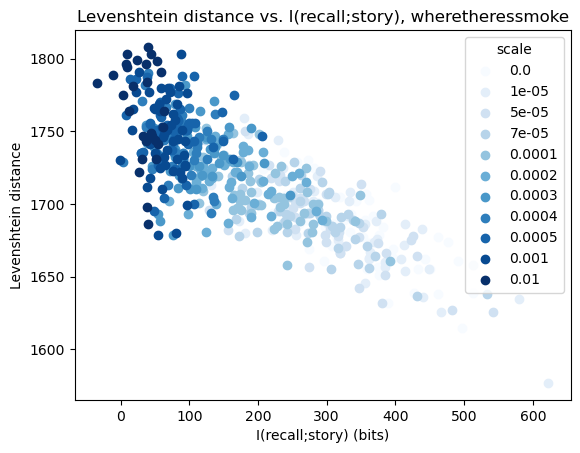

In [21]:
colors = plt.cm.Blues(np.linspace(0, 1, len(scales)))
for color,s in zip(colors,scales):
    indices = np.where(filtered_model_recall_transcript['scale'] == s)[0]
    plt.scatter(filtered_sum_ce_diff[indices],levenshtein_d[indices],color = color,label = s)
plt.legend(title='scale')
plt.xlabel('I(recall;story) (bits)')
plt.ylabel('Levenshtein distance')
plt.title('Levenshtein distance vs. I(recall;story), %s'%story) 

## plot this with human data  

In [22]:
exclusion_dir = os.path.join('/home/jianing/generation/behavior_data/','exclusion')
exclusion_df = pd.read_csv(os.path.join(exclusion_dir,'%s_exclusion.csv'%story))
excluded_subjects = exclusion_df['excluded'].loc[exclusion_df['recall']==1].values 

In [23]:
human_output_dir = os.path.join(save_dir,model_save_dir_name,'prolific_data',story)
with open(os.path.join(human_output_dir,'recall_original_concat_entropy.pkl'),'rb') as f:
    human_recall_original_concat_entropy = pickle.load(f)
with open(os.path.join(human_output_dir,'recall_original_concat.pkl'),'rb') as f:
    human_recall_original_tokens_dict = pickle.load(f)

In [24]:
human_ce_diff = []
human_ce_diff_initial_only = []
all_subjects = []

for i,concat_ce in enumerate(human_recall_original_concat_entropy):
    subject = human_recall_original_tokens_dict['subject_id'][i]
    if subject in excluded_subjects:
        continue
    all_subjects.append(subject)
    start_index = human_recall_original_tokens_dict['original_transcript_start_index'][i]-1 # because there's no BOS in the entropy array 
    post_recall_ce = concat_ce[start_index:]
    assert original_ce.shape == post_recall_ce.shape
    d = (post_recall_ce-original_ce).numpy()
    d_initial_only = d.copy()
    d_initial_only[~word_initial_bool] = np.nan
    human_ce_diff.append(d)
    human_ce_diff_initial_only.append(d_initial_only)
    
human_ce_diff = np.array(human_ce_diff)
human_ce_diff_initial_only= np.array(human_ce_diff_initial_only)


In [ ]:
human_sum_ce_diff = -np.sum(human_ce_diff,axis = 1)

In [26]:
recall_transcript_dir = os.path.join('/home/jianing/generation/behavior_data/recall_transcript',story) 
corrected_transcript = pd.read_csv(os.path.join(recall_transcript_dir,'%s_corrected_recall_transcripts.csv'%story))

In [30]:
levenshtein_d_human = {row['subject']:word_level_edit_distance_polyleven(original_txt,clean_recall(row['corrected transcript'])) for i,row in corrected_transcript.iterrows()}

Text(0.5, 1.0, 'Levenshtein distance vs. I(recall;story), human recalls, wheretheressmoke')

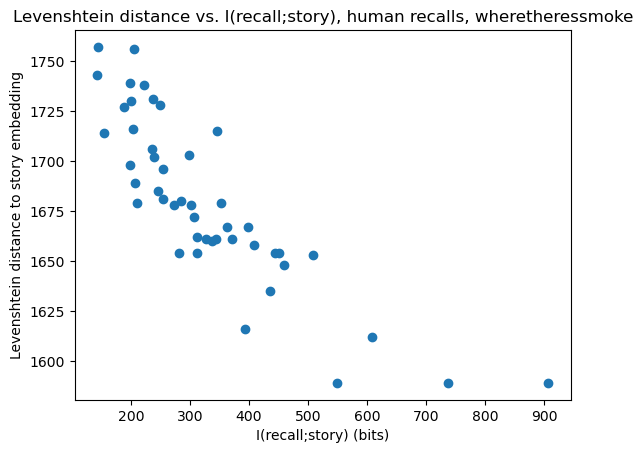

In [ ]:
plt.scatter(human_sum_ce_diff,[levenshtein_d_human[s] for s in all_subjects])
plt.xlabel('I(recall;story) (bits)')
plt.ylabel('Levenshtein distance to story embedding')
plt.title('Levenshtein distance vs. I(recall;story), human recalls, %s'%story) 

## load attention entropy from recall to story 

In [52]:
def get_top_n_heads(head_scores,num):
    '''return top n heads based on the head scores
    Input: head_score, number of heads 
    Output: top n layers number (from n to 1), top n head number (from n to 1)
    '''
    ind = np.unravel_index(np.argsort(head_scores, axis=None), head_scores.shape)
    if num==1:
        return ind[0][-num:][0],ind[1][-num:][0]
    else:
        return ind[0][-num:],ind[1][-num:]

In [53]:
# custom head detection 
attention_head_output_dir = os.path.join(save_dir,model_save_dir_name,'attention_head_test')
mean_head_scores = np.load(os.path.join(attention_head_output_dir,'mean_induction_head_scores.npy'))
mean_duplicate_head_scores = np.load(os.path.join(attention_head_output_dir,'mean_duplicate_token_head_scores.npy'))
top_induction_layer,top_induction_head = get_top_n_heads(mean_head_scores,1)
top_duplicate_layer,top_duplicate_head = get_top_n_heads(mean_duplicate_head_scores,1)

In [34]:
with open(os.path.join(human_output_dir,'original_recall_concat_attention_entropy_bos_False.pkl'),'rb') as f:
    human_original_recall_concat_attention_entropy = pickle.load(f)
with open(os.path.join(human_output_dir,'original_recall_concat_attention_to_original_bos_False.pkl'),'rb') as f:
    human_original_recall_concat_attention_sum = pickle.load(f)
with open(os.path.join(human_output_dir,'recall_tokens.pkl'),'rb') as f:
    human_recall_tokens = pickle.load(f)
assert human_recall_original_tokens_dict['subject_id'] == human_recall_tokens['subject_id']
all_human_recall_token_len = {}
for sub in human_recall_tokens['subject_id']:
    sub_id = human_recall_tokens['subject_id'].index(sub)
    recall_token_len = human_recall_tokens['input_tokenized'][sub_id].shape[1]
    all_human_recall_token_len[sub] = recall_token_len
assert list(all_human_recall_token_len.keys())==human_recall_original_tokens_dict['subject_id']

In [35]:
human_length_norm_attention_entropy = {}
human_mean_attention_to_original = {}

for i,sub in enumerate(list(all_human_recall_token_len.keys())):
    if sub in excluded_subjects:
        continue
    recall_token_len = all_human_recall_token_len[sub]
    human_length_norm_attention_entropy[sub]=human_original_recall_concat_attention_entropy[i]/recall_token_len
    human_mean_attention_to_original[sub] = human_original_recall_concat_attention_sum[i]/recall_token_len

In [36]:
human_top1_dup_att_entropy = {}
human_top1_ind_att_entropy = {}
for sub,sample in human_length_norm_attention_entropy.items():
    sub_ind_att_entropy = sample[top_induction_layer,top_induction_head]
    sub_dup_att_entropy = sample[top_duplicate_layer,top_duplicate_head]
    human_top1_dup_att_entropy[sub]=sub_dup_att_entropy
    human_top1_ind_att_entropy[sub]=sub_ind_att_entropy

## overlay model data with human data 

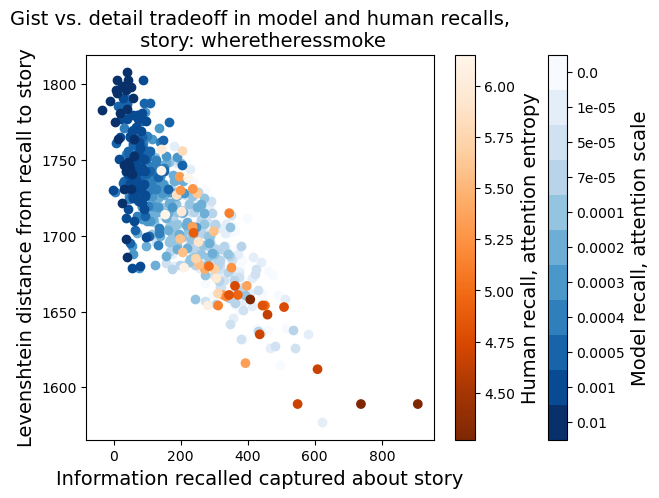

In [38]:
import matplotlib.colors as mcolors

plt.figure(figsize=(7, 5))

# Define the discrete colormap and bounds based on the number of scales
n_scales = len(scales)
cmap = plt.cm.Blues
bounds = np.arange(n_scales + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Scatter plot for model recall
for idx, s in enumerate(scales):
    indices = np.where(filtered_model_recall_transcript['scale'] == s)[0]
    plt.scatter(filtered_sum_ce_diff[indices], levenshtein_d[indices], 
                color=cmap(norm(idx)), label=s)

# Create the discrete colorbar for model recall
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, ticks=np.arange(n_scales) + 0.5)
cbar.set_label('Model recall, attention scale', fontsize=14)
cbar.set_ticks(np.arange(n_scales) + 0.5)
cbar.set_ticklabels(scales)
cbar.ax.invert_yaxis()  # Flip the colorbar upside down

# Second scatter plot with continuous colormap 
color_vals = [human_top1_ind_att_entropy[s] for s in all_subjects]
vmin = np.percentile(np.abs(color_vals), 3)
vmax = np.percentile(np.abs(color_vals), 100 - 3)
sc = plt.scatter(human_sum_ce_diff, [levenshtein_d_human[s] for s in all_subjects],
                 c=color_vals, cmap='Oranges_r', vmin=vmin, vmax=vmax)
cbar2 = plt.colorbar(sc, label='Human recall, attention entropy')
cbar2.set_label('Human recall, attention entropy',fontsize=14) 

# Plot labels and title
plt.xlabel('Information recalled captured about story',fontsize = 14)
plt.ylabel('Levenshtein distance from recall to story',fontsize = 14)
plt.title('Gist vs. detail tradeoff in model and human recalls,\n story: %s' % story,fontsize = 14)

plt.show()


## overlay verbatim recall

In [39]:
verbatim_recall_save_dir = os.path.join(save_dir,model_save_dir_name,'verbatim_recall')
verbatim_df = pd.read_csv(os.path.join(verbatim_recall_save_dir,'%s_verbatim_recall_transcripts.csv'%story))

verbatim_recall_story_dir = os.path.join(verbatim_recall_save_dir,story)
with open(os.path.join(verbatim_recall_story_dir,'recall_original_concat_entropy.pkl'),'rb') as f:
    ver_recall_original_concat_entropy = pickle.load(f)
with open(os.path.join(verbatim_recall_story_dir,'recall_original_concat.pkl'),'rb') as f:
    ver_recall_original_tokens_dict = pickle.load(f)
with open(os.path.join(verbatim_recall_story_dir,'recall_tokens.pkl'),'rb') as f:
    ver_recall_tokens_dict = pickle.load(f)
with open(os.path.join(verbatim_recall_story_dir,'recall_entropy.pkl'),'rb') as f:
    ver_recall_entropy = pickle.load(f)
assert len(ver_recall_original_concat_entropy) == len(ver_recall_tokens_dict['subject_id'])

In [40]:
ver_ce_diff = []
ver_ce_diff_initial_only = []

for i,concat_ce in enumerate(ver_recall_original_concat_entropy):
    start_index = ver_recall_original_tokens_dict['original_transcript_start_index'][i]-1 # because there's no BOS in the entropy array 
    post_recall_ce = concat_ce[start_index:]
    assert original_ce.shape == post_recall_ce.shape
    d = (post_recall_ce-original_ce).numpy()
    d_initial_only = d.copy()
    d_initial_only[~word_initial_bool] = np.nan
    ver_ce_diff.append(d)
    ver_ce_diff_initial_only.append(d_initial_only)
    
ver_ce_diff = np.array(ver_ce_diff)
ver_ce_diff_initial_only= np.array(ver_ce_diff_initial_only)
ver_sum_ce_diff = -np.sum(ver_ce_diff,axis = 1)

In [41]:
verbatim_recall_txt = verbatim_df['corrected transcript'].values
verbatim_recall_txt = clean_recall(verbatim_recall_txt)
verbatim_levenshtein_d = [word_level_edit_distance_polyleven(original_txt,r) for r in verbatim_recall_txt]
verbatim_levenshtein_d = np.array(verbatim_levenshtein_d)

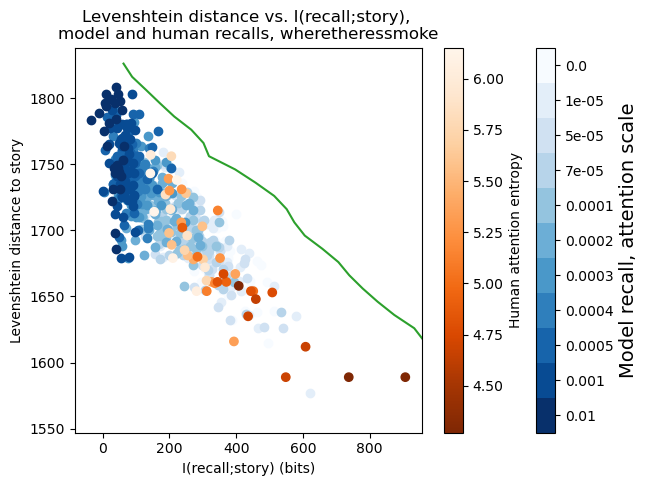

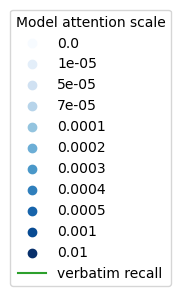

In [42]:
# model 
plt.figure(figsize = (7,5))
# Define the discrete colormap and bounds based on the number of scales
n_scales = len(scales)
cmap = plt.cm.Blues
bounds = np.arange(n_scales + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Scatter plot using index-based color values for the 'Blues' colormap
for idx, s in enumerate(scales):
    indices = np.where(filtered_model_recall_transcript['scale'] == s)[0]
    plt.scatter(filtered_sum_ce_diff[indices], levenshtein_d[indices], 
                color=cmap(norm(idx)), label=s)

# Create the discrete colorbar for 'Blues' colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for the colorbar
cbar = plt.colorbar(sm, ticks=np.arange(n_scales) + 0.5)
cbar.set_label('Model recall, attention scale', fontsize=14)
cbar.set_ticks(np.arange(n_scales) + 0.5)
cbar.set_ticklabels(scales)
cbar.ax.invert_yaxis()  # Flip the colorbar upside down

# human
color_vals = [human_top1_ind_att_entropy[s] for s in all_subjects]
vmin = np.percentile(np.abs(color_vals), 3)
vmax = np.percentile(np.abs(color_vals), 100-3)
plt.scatter(human_sum_ce_diff,[levenshtein_d_human[s] for s in all_subjects],
            c = color_vals,cmap = 'Oranges_r',vmin=vmin,vmax=vmax)
plt.xlabel('I(recall;story) (bits)')
plt.ylabel('Levenshtein distance to story')
plt.title('Levenshtein distance vs. I(recall;story), \nmodel and human recalls, %s'%story) 
plt.colorbar(label='Human attention entropy')

min_ce_diff = np.min(np.concatenate([human_sum_ce_diff,filtered_sum_ce_diff]))
max_ce_diff = np.max(np.concatenate([human_sum_ce_diff,filtered_sum_ce_diff]))

# verbatim recall
min_d = np.min(np.concatenate([levenshtein_d,list(levenshtein_d_human.values())]))
max_d = np.max(np.concatenate([levenshtein_d,list(levenshtein_d_human.values())]))
line, = plt.plot(ver_sum_ce_diff,verbatim_levenshtein_d,color = 'tab:green',label = 'verbatim recall')
plt.xlim([min_ce_diff-50,max_ce_diff+50])
plt.ylim([min_d-30,max_d+30])
#plt.legend(handles=[line], loc='lower right')

# Create a separate figure for the legend
# Capture the legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create the legend in a separate figure
fig_legend = plt.figure(figsize=(2, 2))
plt.legend(handles=handles, labels=labels, loc='center', title='Model attention scale')
plt.axis('off')  # Hide the axes

plt.show()

In [ ]:
# create dictionary for plotting
rate_distortion_dict = {'model_recall_explained_story_info':filtered_sum_ce_diff,
                        'model_levenshtein_d':levenshtein_d,
                        'human_recall_explained_story_info':human_sum_ce_diff,
                        'human_levenshtein_d': [levenshtein_d_human[s] for s in all_subjects],
                        'human_attention_entropy':[human_top1_ind_att_entropy[s] for s in all_subjects],
                        'verbatim_recall_explained_story_info':ver_sum_ce_diff,
                        'verbatim_levenshtein_d':verbatim_levenshtein_d,
                       }
if prompt_number==1:
    with open(os.path.join(save_dir,model_save_dir_name,'rate_distortion','%s_rd_plot_dict.pkl'%story),'wb') as f:
        pickle.dump(rate_distortion_dict,f)
else:
    with open(os.path.join(save_dir,model_save_dir_name,'rate_distortion','%s_rd_plot_dict_prompt_%d.pkl'%(story,prompt_number)),'wb') as f:
        pickle.dump(rate_distortion_dict,f)